In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import time
import numpy as np
import matplotlib.pyplot as plt

In [36]:
def display_num_param(net):
	nb_param = 0
	for param in net.parameters():
	    nb_param += param.numel()
	print('There are {} ({:.2f} million) parameters in this neural network'.format(
		nb_param, nb_param/1e6)
	     )

In [37]:
def get_error( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs 

In [38]:
def show(X):
    if X.dim() == 3 and X.size(0) == 3:
        plt.imshow( np.transpose(  X.numpy() , (1, 2, 0))  )
        plt.show()
    elif X.dim() == 2:
        plt.imshow(   X.numpy() , cmap='gray'  )
        plt.show()
    else:
        print('WRONG TENSOR SIZE')

In [39]:
def show_prob_mnist(p):

    p=p.data.squeeze().numpy()

    ft=15
    label = ('zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight','nine')
    #p=p.data.squeeze().numpy()
    y_pos = np.arange(len(p))*1.2
    target=2
    width=0.9
    col= 'blue'
    #col='darkgreen'

    plt.rcdefaults()
    fig, ax = plt.subplots()

    # the plot
    ax.barh(y_pos, p, width , align='center', color=col)

    ax.set_xlim([0, 1.3])
    #ax.set_ylim([-0.8, len(p)*1.2-1+0.8])

    # y label
    ax.set_yticks(y_pos)
    ax.set_yticklabels(label, fontsize=ft)
    ax.invert_yaxis()  
    #ax.set_xlabel('Performance')
    #ax.set_title('How fast do you want to go today?')

    # x label
    ax.set_xticklabels([])
    ax.set_xticks([])
    #x_pos=np.array([0, 0.25 , 0.5 , 0.75 , 1])
    #ax.set_xticks(x_pos)
    #ax.set_xticklabels( [0, 0.25 , 0.5 , 0.75 , 1] , fontsize=15)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_linewidth(4)


    for i in range(len(p)):
        str_nb="{0:.2f}".format(p[i])
        ax.text( p[i] + 0.05 , y_pos[i] ,str_nb ,
                 horizontalalignment='left', verticalalignment='center',
                 transform=ax.transData, color= col,fontsize=ft)



    plt.show()
    #fig.savefig('pic/prob', dpi=96, bbox_inches="tight")

In [40]:
import os.path
def check_mnist_dataset_exists(path_data='../../data/'):
    flag_train_data = os.path.isfile(path_data + 'mnist/train_data.pt') 
    flag_train_label = os.path.isfile(path_data + 'mnist/train_label.pt') 
    flag_test_data = os.path.isfile(path_data + 'mnist/test_data.pt') 
    flag_test_label = os.path.isfile(path_data + 'mnist/test_label.pt') 
    if flag_train_data==False or flag_train_label==False or flag_test_data==False or flag_test_label==False:
        print('MNIST dataset missing - downloading...')
        import torchvision
        import torchvision.transforms as transforms
        trainset = torchvision.datasets.MNIST(root=path_data + 'mnist/temp', train=True,
                                                download=True, transform=transforms.ToTensor())
        testset = torchvision.datasets.MNIST(root=path_data + 'mnist/temp', train=False,
                                               download=True, transform=transforms.ToTensor())
        train_data=torch.Tensor(60000,28,28)
        train_label=torch.LongTensor(60000)
        for idx , example in enumerate(trainset):
            train_data[idx]=example[0].squeeze()
            train_label[idx]=example[1]
        torch.save(train_data,path_data + 'mnist/train_data.pt')
        torch.save(train_label,path_data + 'mnist/train_label.pt')
        test_data=torch.Tensor(10000,28,28)
        test_label=torch.LongTensor(10000)
        for idx , example in enumerate(testset):
            test_data[idx]=example[0].squeeze()
            test_label[idx]=example[1]
        torch.save(test_data,path_data + 'mnist/test_data.pt')
        torch.save(test_label,path_data + 'mnist/test_label.pt')
    return path_data

Download the data

In [41]:
data_path=check_mnist_dataset_exists()

train_data=torch.load(data_path+'mnist/train_data.pt')
train_label=torch.load(data_path+'mnist/train_label.pt')
test_data=torch.load(data_path+'mnist/test_data.pt')
test_label=torch.load(data_path+'mnist/test_label.pt')

MNIST dataset missing - downloading...


OSError: ignored

Make a one layer net class.

In [ ]:
class one_layer_net(nn.Module):

    def __init__(self, input_size, output_size):
        super(one_layer_net , self).__init__()
        self.linear_layer = nn.Linear( input_size, output_size , bias=False)
        
    def forward(self, x):
        scores = self.linear_layer(x)
        return scores

Build the net

In [ ]:
net=one_layer_net(784,10)

print(net)
display_num_param(net)

one_layer_net(
  (linear_layer): Linear(in_features=784, out_features=10, bias=False)
)
There are 7840 (0.01 million) parameters in this neural network


Choose the criterion, batchsize

In [ ]:
criterion = nn.CrossEntropyLoss()

bs=200

Evaluate on test set

In [ ]:
def eval_on_test_set():

    running_error=0
    num_batches=0

    for i in range(0,10000,bs):

        minibatch_data =  test_data[i:i+bs]
        minibatch_label= test_label[i:i+bs]

        inputs = minibatch_data.view(bs,784)

        scores=net( inputs ) 

        error = get_error( scores , minibatch_label)

        running_error += error.item()

        num_batches+=1


    total_error = running_error/num_batches
    print( 'test error  = ', total_error*100 ,'percent')

Training loop

In [ ]:
start = time.time()

lr = 0.05 # initial learning rate

for epoch in range(200):
    
    # learning rate strategy : divide the learning rate by 1.5 every 10 epochs
    if epoch%10==0 and epoch>10: 
        lr = lr / 1.5
    
    # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.SGD( net.parameters() , lr=lr )
        
    running_loss=0
    running_error=0
    num_batches=0
    
    shuffled_indices=torch.randperm(60000)
 
    for count in range(0,60000,bs):
        
        # forward and backward pass
    
        optimizer.zero_grad()
        
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  train_data[indices]
        minibatch_label= train_label[indices]

        inputs = minibatch_data.view(bs,784)

        inputs.requires_grad_()

        scores=net( inputs ) 

        loss =  criterion( scores , minibatch_label) 
        
        loss.backward()

        optimizer.step()
        
        
        # compute some stats
        
        running_loss += loss.detach().item()
               
        error = get_error( scores.detach() , minibatch_label)
        running_error += error.item()
        
        num_batches+=1
    
    
    # once the epoch is finished we divide the "running quantities"
    # by the number of batches
    
    total_loss = running_loss/num_batches
    total_error = running_error/num_batches
    elapsed_time = time.time() - start
    
    # every 10 epoch we display the stats 
    # and compute the error rate on the test set  
    
    if epoch % 10 == 0 : 
    
        print(' ')
        
        print('epoch=',epoch, ' time=', elapsed_time,
              ' loss=', total_loss , ' error=', total_error*100 ,'percent lr=', lr)
        
        eval_on_test_set()

 
epoch= 0  time= 0.6397364139556885  loss= 0.8330492540200551  error= 17.788333396116894 percent lr= 0.05
test error  =  12.080000162124634 percent
 
epoch= 10  time= 3.962064504623413  loss= 0.33096947133541105  error= 9.135000129540762 percent lr= 0.05
test error  =  8.679999828338623 percent
 
epoch= 20  time= 7.235661029815674  loss= 0.3061979689200719  error= 8.54666664203008 percent lr= 0.03333333333333333
test error  =  8.200000166893005 percent
 
epoch= 30  time= 10.47760272026062  loss= 0.29767328957716627  error= 8.274999698003132 percent lr= 0.022222222222222223
test error  =  8.079999923706055 percent
 
epoch= 40  time= 13.740451574325562  loss= 0.29345020269354183  error= 8.148333271344503 percent lr= 0.014814814814814815
test error  =  8.009999990463257 percent
 
epoch= 50  time= 16.98484230041504  loss= 0.2910269038875898  error= 8.089999874432882 percent lr= 0.009876543209876543
test error  =  7.989999771118164 percent
 
epoch= 60  time= 20.260212659835815  loss= 0.289

Choose image at random from the test set and see how good/bad are the predictions

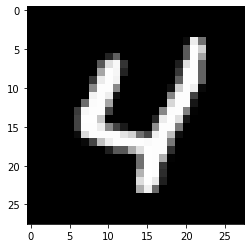

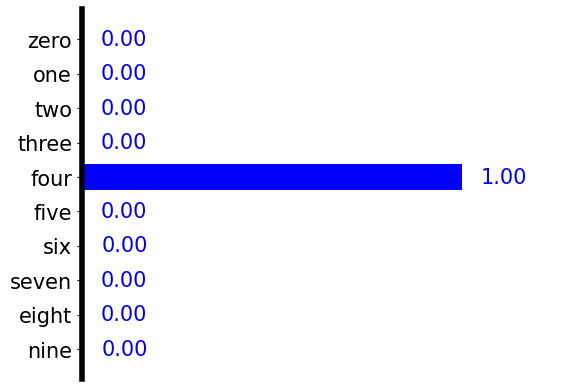

In [ ]:
# choose a picture at random
idx=randint(0, 10000-1)
im=test_data[idx]

# diplay the picture
show(im)

# feed it to the net and display the confidence scores
scores =  net( im.view(1,784)) 
probs= F.softmax(scores, dim=1)
show_prob_mnist(probs)